In [181]:
!pip install pmdarima
!pip install yfinance --upgrade --no-cache-dir

In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import plotly.express as px
import yfinance as yf
from datetime import datetime
from pandas.testing import assert_frame_equal
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.util._decorators import Appender
import statsmodels.api as sm
from pmdarima import auto_arima
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import GRU, SimpleRNN, Dense, Dropout, Masking, Embedding
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import tensorflow as tf
from tensorflow import keras 
#Bibliotecas para utilização do Keras
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from scipy import stats


from pandas.plotting import lag_plot

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [183]:
#Funcao para retornar os dados de um fundo especifico
def get_fundos(cd_fundo,dt_inicio,dt_fim,setor=False):
  dados_fundo = yf.download(cd_fundo,start=dt_inicio, end = dt_fim)
  if setor:
   dados_fundo['setor'] = setor
  
  return dados_fundo.Close

In [184]:
# Qual fundo imobiliário 
hglg = 'HGLG11.SA'
#Define o periodo das operacoes realizadas no mercado (B3)
dt_inicio = datetime(2015,1,1)
dt_fim = datetime(2021,6,30)

#Definir periodo de previsão do algoritmo
d_periodo = 90
df_fundo_yfinance = pd.DataFrame()

#define um dicionario vazio
fundos_dict = {}
#extrair informações dos fundos imobiliários yfinance
try:
  df_hglg = get_fundos(hglg,dt_inicio,dt_fim)
except:
  print("Erro ao consultar o fundo: "+ cod_fundo)

[*********************100%***********************]  1 of 1 completed


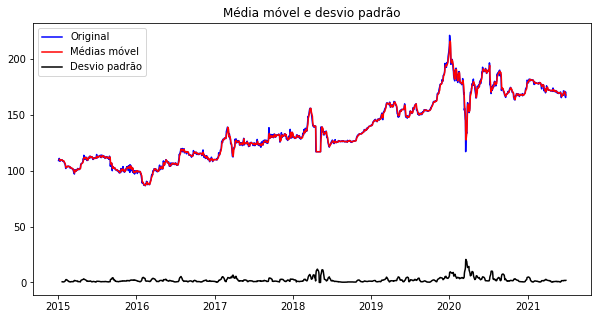

Resultados do teste Dickey Fuller
Teste de hipotese           -1.133373
p-value                      0.701581
No. de lags utilizados      25.000000
Numero de observacoes     1577.000000
Valor critico (1%)          -3.434503
Valor critico (5%)          -2.863374
Valor critico (10%)         -2.567747
dtype: float64


In [185]:
#Verificar se a serie é estacionária
def test_stationarity(timeseries):
    #Determinando a médias/std (desvio)
    rolmean = timeseries.rolling(3).mean()
    rolstd = timeseries.rolling(12).std()
    #Definindo o tamanho da área do gráfico
    plt.figure(figsize=(10,5))
    #Gerando o gráfico com as estatisticas:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Médias móvel')
    plt.plot(rolstd, color='black', label = 'Desvio padrão')
    plt.legend(loc='best')
    plt.title('Média móvel e desvio padrão')
    plt.show(block=False)
    
    print("Resultados do teste Dickey Fuller")
    adft = adfuller(timeseries,autolag='AIC')
    # saída para dft nos dará sem definir quais são os valores.
    #portanto, escrevemos manualmente quais valores isso explica usando um loop for
    output = pd.Series(adft[0:4],index=['Teste de hipotese','p-value','No. de lags utilizados','Numero de observacoes'])
    for key,values in adft[4].items():
        output['Valor critico (%s)'%key] =  values
    print(output)
    
test_stationarity(df_hglg)

Através do gráfico acima, podemos ver o aumento da média e do desvio padrão e, portanto, nossa série não é estacionária.

O valor do p-value é maior que 0,05, sendo assim, não devemos rejeitar a hipotese nula.

A estatística de teste (-1,13) é maior que os valores críticos (-3,43, -2,86 e -2,56).


In [186]:
decomposicao = seasonal_decompose(df_hglg,period=(len(df_hglg) //2), model='multiplicative')

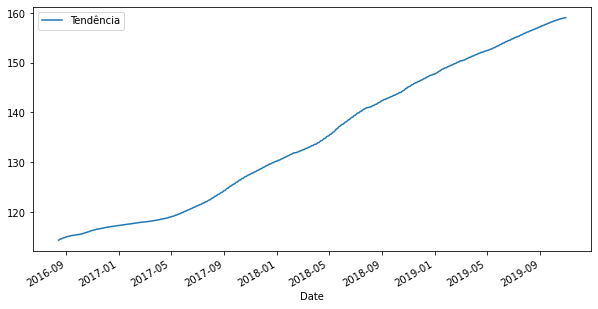

In [187]:
decomposicao.trend.plot(figsize=(10,5),label='Tendência').legend()

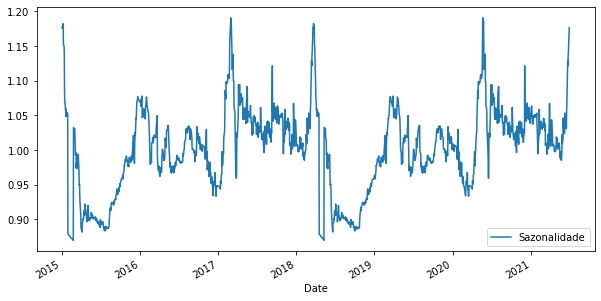

In [188]:
decomposicao.seasonal.plot(figsize=(10,5),label='Sazonalidade').legend()

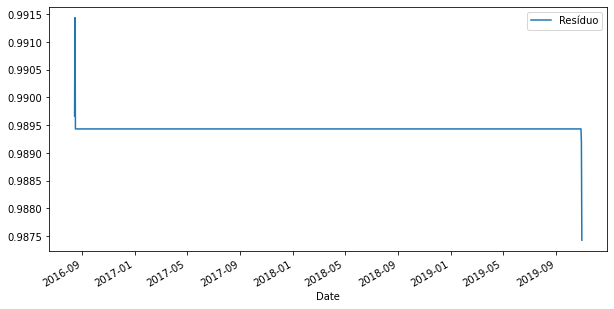

In [189]:
decomposicao.resid.plot(figsize=(10,5),label='Resíduo').legend()


#Previsões GRU

A GRU (Gated  Recurrent  Unit)  é a nova geração de redes neurais recorrentes e é bastante semelhante a uma LSTM. As GRUs se livraram do estado da célula e usaram o estado oculto para transferir informações. Essa arquitetura possui apenas dois portões, um portão de redefinição (reset gate) e um portão de atualização (update date). As GRUs são uma versão melhorada da rede neural recorrente padrão. Veja abaixo o que as torna tão especiais e eficazes

##  Construção do modelo GRU

In [190]:
#Split da base de dados para gerar base de teste e treinamento. Sem embaralhar os dados.
df_hglg_lstm = df_hglg.copy()
df_hglg_lstm = pd.DataFrame({'Close':df_hglg_lstm.values},index=df_hglg_lstm.index)
train_hglg_gru, test_hglg_gru = train_test_split(df_hglg_lstm, test_size=0.056,shuffle=False)

In [191]:
len(train_hglg_gru), len(test_hglg_gru)

(1513, 90)

In [192]:
#Normalizando os dados para o formato que a rede estabelece.
train_gru = train_hglg_gru.iloc[:,0:1].values
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled_gru = scaler.fit_transform(train_gru) 

In [193]:
#Criação de uma estrutura de dados com 90 timesteps e 1 saída que neste caso será o preço de fechamento da ação
timesteps = 20
x_train_gru = []
y_train_gru = []
for i in range(timesteps, train_gru.shape[0]):
    x_train_gru.append(train_scaled_gru[i-timesteps:i, 0])
    y_train_gru.append(train_scaled_gru[i, 0])
x_train_gru, y_train_gru = np.array(x_train_gru), np.array(y_train_gru)

In [194]:
#Reshaping o dataframe de treinamento 
#Sendo o segundo parâmetro como: 
       #x_train_gru.shape[0] = batch_size, que é o número de preços de fechamento do período de treinamento
       #x_train_gru.shape[1] = time_step, que é o número de preços anteriores
       #input_dim = 1, que indica que será usado o preço de fechamento
x_train_gru = np.reshape(x_train_gru, (x_train_gru.shape[0], x_train_gru.shape[1], 1))

In [195]:
# Inicialização da RNN
model_rnn = Sequential()

# Adiciona a primeira camada GRU com o Dropout 
model_rnn.add(GRU(units = 128, return_sequences = True, input_shape = (x_train_gru.shape[1], 1)))
model_rnn.add(Dropout(0.3))

# Adiciona a segunda camada GRU com o Dropout
model_rnn.add(GRU(units = 64))
model_rnn.add(Dropout(0.3))

# Adiciona a camada de saída 
model_rnn.add(Dense(10))

# Compila a RNN, neste caso utilizando o otimizador 'Adam' e utilizando as métricas de erro médio absoluto
model_rnn.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mean_absolute_error'])

# Faz o treinamento da RNN utilizando o dataset de treinamento - treinando o modelo para 100 épocas
model_rnn.fit(x_train_gru, y_train_gru, epochs = 100, batch_size = 32) 

#Mostra o resumo do modelo
model_rnn.summary()

Epoch 1/100
47/47 [==============================] - 5s 30ms/step - loss: 0.0300 - mean_absolute_error: 0.1178
Epoch 2/100
47/47 [==============================] - 1s 30ms/step - loss: 0.0075 - mean_absolute_error: 0.0607
Epoch 3/100
47/47 [==============================] - 1s 30ms/step - loss: 0.0063 - mean_absolute_error: 0.0554
Epoch 4/100
47/47 [==============================] - 1s 30ms/step - loss: 0.0052 - mean_absolute_error: 0.0495
Epoch 5/100
47/47 [==============================] - 1s 30ms/step - loss: 0.0045 - mean_absolute_error: 0.0467
Epoch 6/100
47/47 [==============================] - 1s 30ms/step - loss: 0.0042 - mean_absolute_error: 0.0441
Epoch 7/100
47/47 [==============================] - 1s 30ms/step - loss: 0.0035 - mean_absolute_error: 0.0407
Epoch 8/100
47/47 [==============================] - 1s 30ms/step - loss: 0.0034 - mean_absolute_error: 0.0401
Epoch 9/100
47/47 [==============================] - 1s 30ms/step - loss: 0.0029 - mean_absolute_error: 0.0369
E

In [196]:
#Carregamentos dos dados de teste para fazer as predições
test_gru = test_hglg_gru.iloc[:,0:1].values #seleciona o preço de fechamento

combine = pd.concat((train_hglg_gru['Close'], test_hglg_gru['Close']), axis = 0)

# Tratamento do conjunto de teste considerando os timesteps anteriores
test_inputs = combine[len(combine) - len(test_hglg_gru) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)

# Normalização dos dados
test_inputs = scaler.transform(test_inputs)


x_test_gru = []
for i in range(timesteps, test_hglg_gru.shape[0]+timesteps):
    x_test_gru.append(test_inputs[i-timesteps:i, 0])
x_test_gru = np.array(x_test_gru)
x_test_gru = np.reshape(x_test_gru, (x_test_gru.shape[0], x_test_gru.shape[1], 1))
predictions_gru = model_rnn.predict(x_test_gru)

#Desnormatizar os dados
predictions_gru = scaler.inverse_transform(predictions_gru)

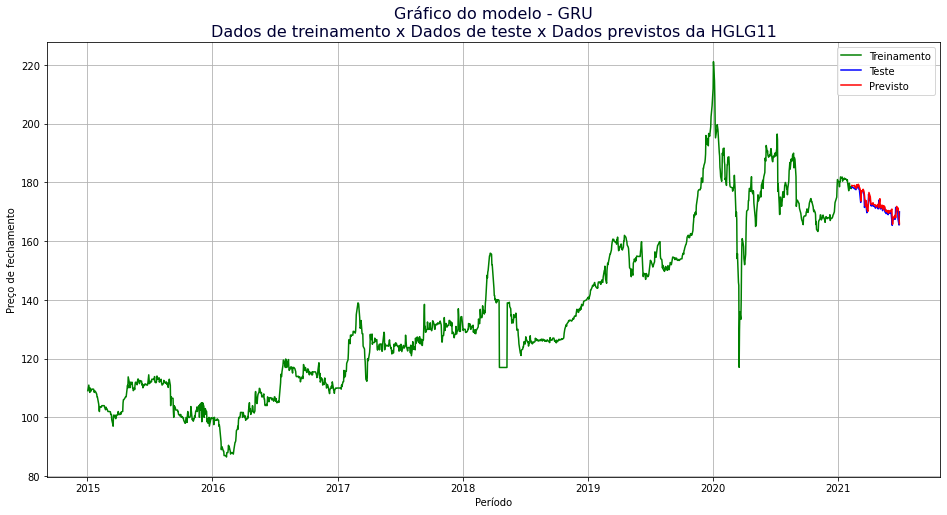

In [197]:
#Gerando gráfico dos dados de treinamento, teste e previsão
plt.figure(figsize=(16,8))
line1, = plt.plot(train_hglg_gru.index, train_hglg_gru, color='green')
line2, = plt.plot(test_hglg_gru.index, test_gru, color = 'blue' )
line3 = plt.plot(test_hglg_gru.index, predictions_gru[0:,1], color = 'red')
plt.title('Gráfico do modelo - GRU\nDados de treinamento x Dados de teste x Dados previstos da HGLG11', fontsize=16,color='#000033')
plt.xlabel('Período')
plt.ylabel('Preço de fechamento')
line1.set_label("Treinamento")
line2.set_label("Teste")
line3[0].set_label("Previsto")
plt.legend()
plt.grid(True)
plt.show()

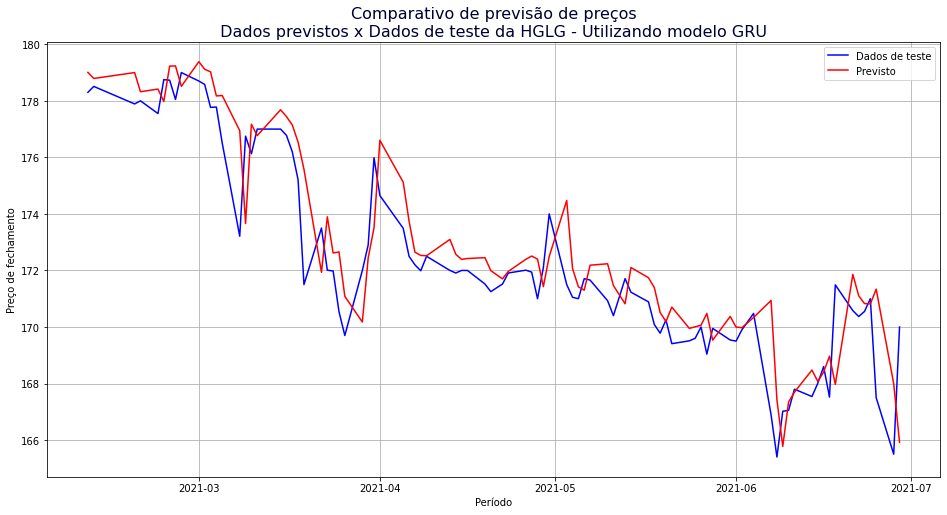

In [198]:
plt.figure(figsize=(16,8))
plt.plot(test_hglg_gru.index, test_gru, color = 'blue', label = 'Dados de teste')
line1 = plt.plot(test_hglg_gru.index, list(predictions_gru[:,1]), color = 'red')
plt.title('Comparativo de previsão de preços\n Dados previstos x Dados de teste da HGLG - Utilizando modelo GRU ', fontsize=16, color='#000033')
plt.xlabel('Período')
plt.ylabel('Preço de fechamento')
line1[0].set_label('Previsto')
plt.legend()
plt.grid(True)
plt.show()

In [199]:
#Cálculo do erro o modelo
mae_gru = round(mean_absolute_error(test_gru,(predictions_gru[0:,1])),2)
mse_gru = round(mean_squared_error(test_gru,((predictions_gru[0:,1]))),2)
rmse_gru = round(np.sqrt(mean_squared_error(test_gru,((predictions_gru[0:,1])))),2)
print('MAE: ', mae_gru)
print('MSE: ', mse_gru)
print('RMSE: ', rmse_gru)

MAE:  1.1
MSE:  2.17
RMSE:  1.47


# Previsões com ARIMA

## Modelo ARIMA

In [200]:
df_hglg

Date
2015-01-02    109.099998
2015-01-05    111.000000
2015-01-06    110.000000
2015-01-07    109.000000
2015-01-08    108.500000
                 ...    
2021-06-23    170.550003
2021-06-24    171.000000
2021-06-25    167.500000
2021-06-28    165.500000
2021-06-29    170.000000
Name: Close, Length: 1603, dtype: float64

In [201]:
#Separando a base de treinamento e teste.
train_data, test_data = train_test_split(df_hglg, test_size=0.056,shuffle=False)

In [202]:
print('Dias para previsão:'+ str(len(test_data)) + ' dias , data inicio:' + 
      str(test_data.index.min()) +' e data fim:' + str(test_data.index.max()))

Dias para previsão:90 dias , data inicio:2021-02-10 00:00:00 e data fim:2021-06-29 00:00:00


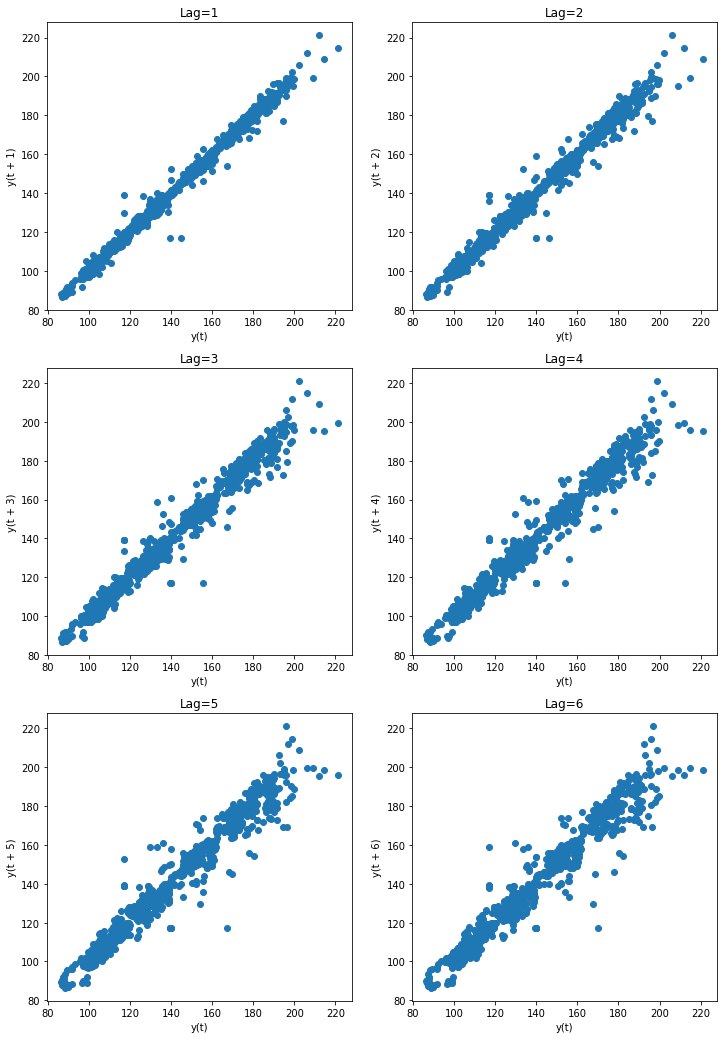

In [203]:
#Plotagem da Autocorrelação
fig, axes = plt.subplots(3, 2, figsize=(12, 18))
plt.title('Autocorrelação do fundo HGLG11')

# Coordenadas dos eixos para plotagem
ax_idcs = [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1),
    (2, 0),
    (2, 1)
]

for lag, ax_coords in enumerate(ax_idcs, 1):
    ax_row, ax_col = ax_coords
    axis = axes[ax_row][ax_col]
    lag_plot(train_data, lag=lag, ax=axis)
    axis.set_title(f"Lag={lag}")
plt.savefig('lags.png')
plt.show()

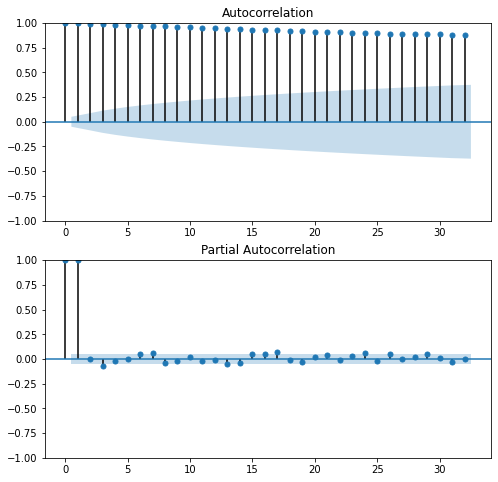

In [204]:
#Verificar ACF e PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
plot_acf(train_data, ax = ax1)
plot_pacf(train_data, ax = ax2, method='yw')
plt.show()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=14341.292, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=12411.469, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=19192.311, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=6666.066, Time=0.25 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=6667.952, Time=2.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=6660.687, Time=0.35 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=10996.014, Time=1.21 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=6661.812, Time=0.72 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=6661.437, Time=1.05 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=9952.799, Time=1.58 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=6662.971, Time=2.81 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=6663.993, Time=0.67 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0] intercept
Total fit time: 11.257 seconds
                      

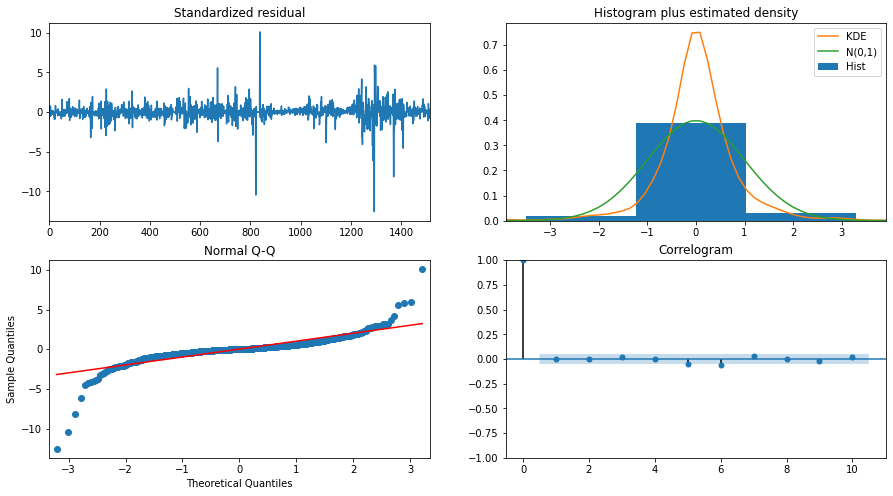

In [205]:
modelo_arima_s = auto_arima(train_data, seasonal=True,start_p=0, start_q=0, max_p=3,max_q=3,d=1,D=1,trace=True,m=1, stationary=True)

print(modelo_arima_s.summary())
modelo_arima_s.plot_diagnostics(figsize=(15,8))
plt.show()

In [206]:
#Predição dos valores
previsoes = pd.DataFrame(modelo_arima_s.predict(n_periods=len(test_data)),index=test_data.index)
intervalo_confianca = modelo_arima_s.predict(len(test_data), return_conf_int = True)

In [207]:
treinamento_arima = pd.DataFrame(train_data)
treinamento_arima.set_index(train_data.index,inplace=True)
previsoes.columns = ['previsoes']


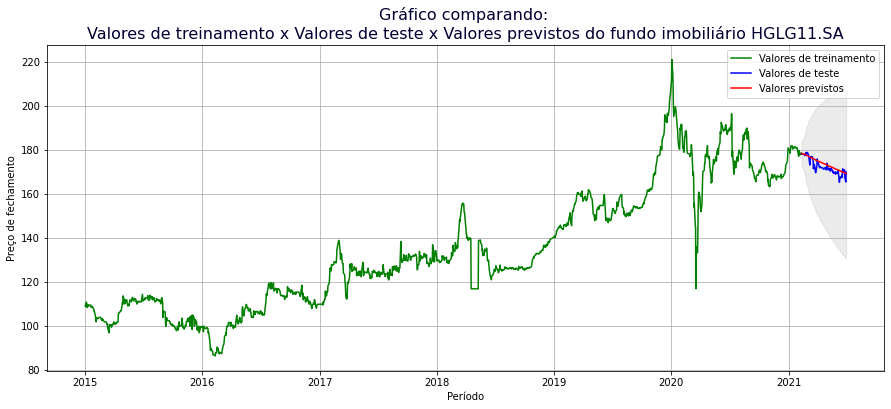

In [208]:

plt.figure(figsize=(15,6))
plt.title('Gráfico comparando: \nValores de treinamento x Valores de teste x Valores previstos do fundo imobiliário HGLG11.SA', fontsize=16, color='#000033')
plt.fill_between(test_data.index, intervalo_confianca[1][:,0], intervalo_confianca[1][:,1], 
                 color='k', alpha=.08)
plt.plot(train_data, color='green', label = 'Valores de treinamento')
plt.plot(test_data, color = 'blue', label = 'Valores de teste')
plt.plot(previsoes.previsoes, color = 'red', label = 'Valores previstos')
plt.xlabel('Período')
plt.ylabel('Preço de fechamento')
plt.legend()
plt.grid(True)
#plt.savefig('arima1.pdf')
plt.show()

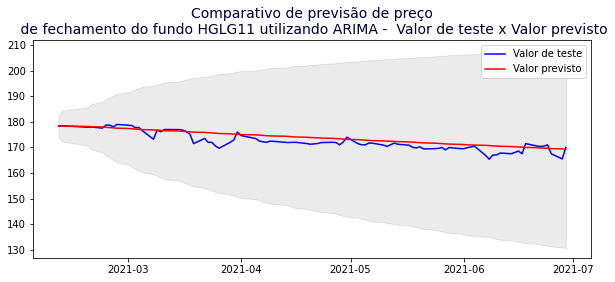

In [209]:
plt.figure(figsize=(10,4))
plt.fill_between(test_data.index, intervalo_confianca[1][:,0], intervalo_confianca[1][:,1], 
                 color='k', alpha=.08)
plt.plot(test_data, color='blue', label='Valor de teste')
plt.plot(previsoes, color='red', label='Valor previsto')
plt.title("Comparativo de previsão de preço\n de fechamento do fundo HGLG11 utilizando ARIMA -  Valor de teste x Valor previsto"
          ,color='#000033',fontsize=14)
plt.legend()

# Previsão com o Facebook Prophet

In [210]:
!pip install fbprophet

## Separar base de teste e base de treinamento

In [211]:
#Criar novo dataset para adequar variaveis ds e y
df_hglg_p = pd.DataFrame()

In [212]:
#Tranformando o dataset no shape necessário para o modelo Prophet (df,y)
df_hglg_p['ds'], df_hglg_p['y'] = df_hglg.index, df_hglg.values

In [213]:
df_hglg_p

,ds,y
0,2015-01-02,109.099998
1,2015-01-05,111.000000
2,2015-01-06,110.000000
3,2015-01-07,109.000000
4,2015-01-08,108.500000
...,...,...
1598,2021-06-23,170.550003
1599,2021-06-24,171.000000
1600,2021-06-25,167.500000
1601,2021-06-28,165.500000


In [214]:
#Split da base de dados para gerar base de teste e treinamento. Sem embaralhar os dados.
df_hglg_treino, df_hglg_teste = train_test_split(df_hglg_p, test_size=0.056,shuffle=False)


In [215]:
len(df_hglg_teste),df_hglg_teste.ds.min(),df_hglg_teste.ds.max()

(90, Timestamp('2021-02-10 00:00:00'), Timestamp('2021-06-29 00:00:00'))

In [216]:
len(df_hglg_treino),df_hglg_treino.ds.min(),df_hglg_treino.ds.max()

(1513, Timestamp('2015-01-02 00:00:00'), Timestamp('2021-02-09 00:00:00'))

In [217]:
len(df_hglg),df_hglg.index.min(),df_hglg.index.max()

(1603, Timestamp('2015-01-02 00:00:00'), Timestamp('2021-06-29 00:00:00'))

## Construção do modelo e previsoes

In [218]:

df_hglg_treino.set_index('ds', inplace=True)
df_hglg_treino['ds'] = df_hglg_treino.index

In [219]:
df_hglg_treino

,y,ds
ds,,
2015-01-02,109.099998,2015-01-02
2015-01-05,111.000000,2015-01-05
2015-01-06,110.000000,2015-01-06
2015-01-07,109.000000,2015-01-07
2015-01-08,108.500000,2015-01-08
...,...,...
2021-02-03,179.750000,2021-02-03
2021-02-04,177.990005,2021-02-04
2021-02-05,178.570007,2021-02-05


In [220]:
#Definindo o modelo do prophet - Desativando a sazonalidade diária.
modelo_prophet = Prophet(changepoint_prior_scale=0.1, interval_width=0.85,daily_seasonality=False)
#modelo_prophet = Prophet(daily_seasonality=False)


In [221]:
#Ajustando o modelo com a base de treinamento
modelo_prophet.fit(df_hglg_treino)

In [222]:
#Realizar a previsão de acordo com as datas de teste.
previsao_prophet = modelo_prophet.predict(pd.DataFrame(df_hglg_teste['ds']))

In [223]:
previsao_prophet[['ds','yhat']]

,ds,yhat
0,2021-02-10,175.608480
1,2021-02-11,175.808574
2,2021-02-18,176.425765
3,2021-02-19,176.772253
4,2021-02-22,176.934141
...,...,...
85,2021-06-23,174.128408
86,2021-06-24,174.295594
87,2021-06-25,174.550280
88,2021-06-28,174.463250


In [224]:
#Separandos os valores previstos e valores reais
y_prev = previsao_prophet[['ds','yhat']]
y_real = df_hglg_teste.copy()

In [225]:
y_prev.set_index('ds',inplace=True)
y_real.set_index('ds',inplace=True)


## Apresentação dos dados e avaliação do modelo Prophet

In [226]:
treinamento_p = df_hglg_treino.copy()
treinamento_p.set_index(treinamento_p['ds'],inplace=True)
treinamento_p.drop(columns={'ds'})

,y
ds,
2015-01-02,109.099998
2015-01-05,111.000000
2015-01-06,110.000000
2015-01-07,109.000000
2015-01-08,108.500000
...,...
2021-02-03,179.750000
2021-02-04,177.990005
2021-02-05,178.570007


In [227]:
y_real

,y
ds,
2021-02-10,178.300003
2021-02-11,178.509995
2021-02-18,177.889999
2021-02-19,178.000000
2021-02-22,177.550003
...,...
2021-06-23,170.550003
2021-06-24,171.000000
2021-06-25,167.500000


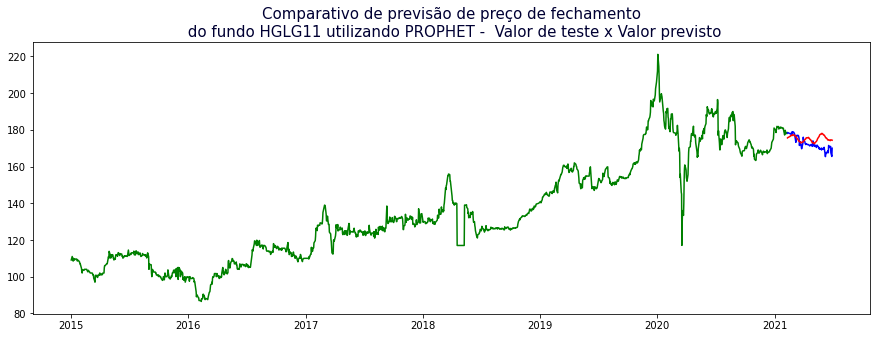

In [228]:
plt.figure(figsize=(15,5))
plt.plot(treinamento_p.index, treinamento_p.y,  color = 'green', label='Treinamento')
plt.plot(y_real.index, y_real.y, color='blue', label='Valor de teste')
plt.plot(y_prev.index, y_prev.yhat, color = 'red', label='Valor previsto')
plt.title("Comparativo de previsão de preço de fechamento\n do fundo HGLG11 utilizando PROPHET -  Valor de teste x Valor previsto",color='#000033',fontsize=15)
plt.show()




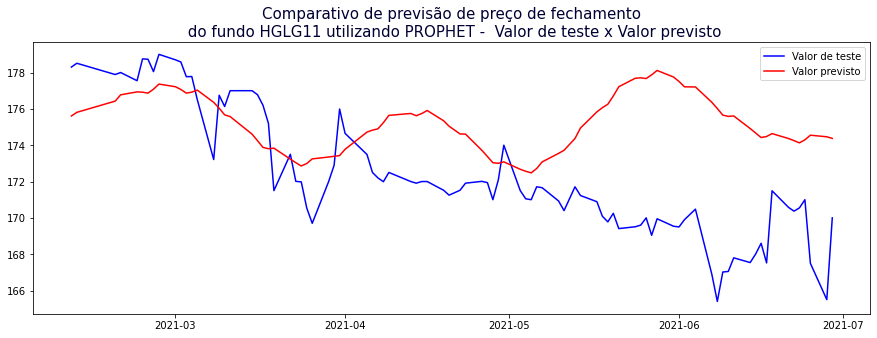

In [229]:
plt.figure(figsize=(15,5))

plt.plot(y_real, scalex=True, color='blue', label='Valor de teste')
plt.plot(y_prev, scalex=True, color = 'red', label='Valor previsto')

plt.title("Comparativo de previsão de preço de fechamento\n do fundo HGLG11 utilizando PROPHET -  Valor de teste x Valor previsto",color='#000033',fontsize=15)
plt.legend()

In [230]:
rse_prophet = mean_absolute_error(y_real,y_prev)
rse_prophet

3.6707517434437857

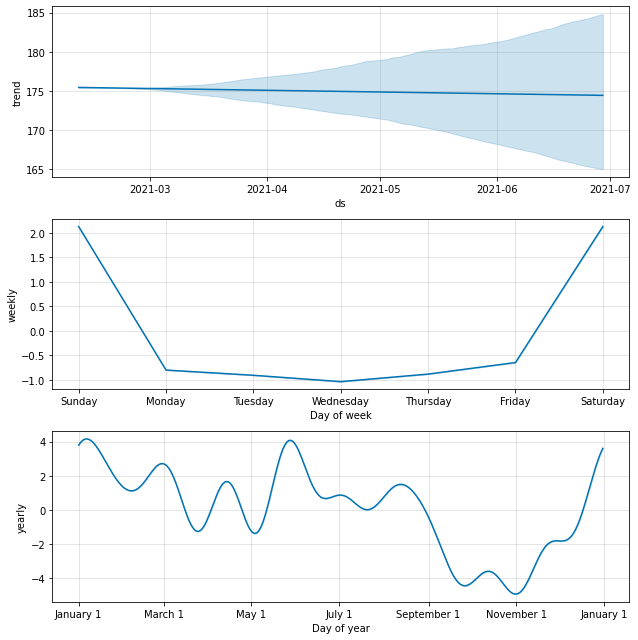

In [231]:
fig = modelo_prophet.plot_components(previsao_prophet)


#Avaliando os modelos

In [232]:
#Cálculo do erro do ARIMA
mse_arima = round(mean_squared_error(test_data, previsoes.previsoes),2)
print('MSE: '+str(mse_arima))
mae_arima = round(mean_absolute_error(test_data, previsoes.previsoes),2)
print('MAE: '+str(mae_arima))
rmse_arima = round(math.sqrt(mae_arima),2)
print('RMSE: '+str(rmse_arima))

MSE: 4.66
MAE: 1.78
RMSE: 1.33


In [233]:
df_hglg_teste.set_index('ds', inplace=True)

In [234]:
#Cálculo do erro do PROPHET
mse_prophet = round(mean_squared_error(df_hglg_teste, previsao_prophet.yhat.values),2)
print('MSE: '+str(mse_prophet))
mae_prophet = round(mean_absolute_error(df_hglg_teste, previsao_prophet.yhat.values),2)
print('MAE: '+str(mae_prophet))
rmse_prophet = round(math.sqrt(mae_prophet),2)
print('RMSE: '+str(rmse_prophet))

MSE: 20.82
MAE: 3.67
RMSE: 1.92


## R2 - Coeficiente de determinação

In [269]:
r2_gru = abs(round(r2_score(test_gru, predictions_gru[:,1]),2))
r2_arima = abs(round(r2_score(test_data,previsoes.previsoes),2))
r2_prophet = abs(round(r2_score(y_real,y_prev),2))

In [270]:
r2 =  pd.DataFrame({'MODELOS': ['ARIMA','PROPHET','GRU'],
                    'R2' :[ str(r2_arima*100) + '%', str(r2_prophet*100) +'%', str(r2_gru*100) + '%']})

In [271]:
r2

,MODELOS,R2
0,ARIMA,61.0%
1,PROPHET,56.0%
2,GRU,82.0%


#Resultado

In [272]:
resultado = pd.DataFrame({'MÉTRICAS': ['MAE','MSE','RMSE','R2'],
                          'ARIMA':[mae_arima, mse_arima,rmse_arima, str(r2_arima*100) + '%'], 
                          'PROPHET':[mae_prophet,mse_prophet,rmse_prophet,str(r2_prophet*100) +'%'],
                          'GRU':[mae_gru, mse_gru,rmse_gru,str(r2_gru*100) + '%']})


In [273]:
resultado

,MÉTRICAS,ARIMA,PROPHET,GRU
0,MAE,1.78,3.67,1.1
1,MSE,4.66,20.82,2.17
2,RMSE,1.33,1.92,1.47
3,R2,61.0%,56.0%,82.0%


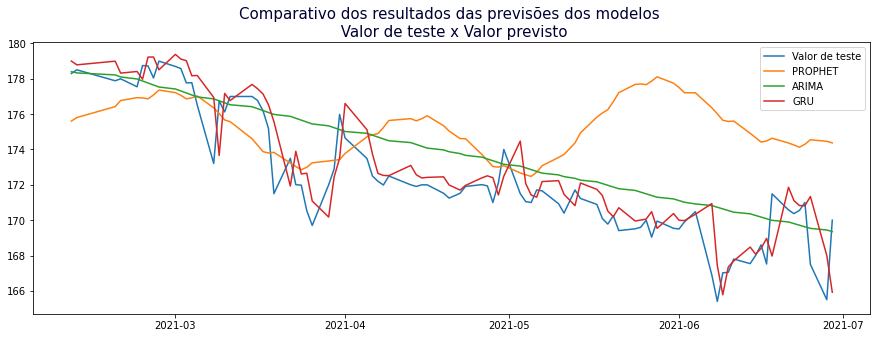

In [240]:
plt.figure(figsize=(15,5))
plt.plot(y_real, scalex=True,  label='Valor de teste')
plt.plot(y_prev, scalex=True,  label='PROPHET')
plt.plot(previsoes,  label='ARIMA')
plt.plot(test_hglg_gru.index, list(predictions_gru[:,1]),  label='GRU')
plt.title("Comparativo dos resultados das previsões dos modelos \n Valor de teste x Valor previsto",color='#000033',
          fontsize=15)
plt.legend()
plt.show()

## Comparativo dos valores reais x valores de previsão dos modelos

In [241]:
pred_gru = pd.DataFrame({'Close':list(predictions_gru[:,1])}, index=y_real.index)
valores_prev = pd.DataFrame({'VALOR_TESTE':round(y_real.y,2).values,
                             'PREVISAO_ARIMA':round(previsoes.previsoes,2).values,
                              'PREVISAO_PROPHET': round(y_prev.yhat,2).values,
                             'PREVISAO_GRU': round(pred_gru.Close,2)},index=y_real.index)
valores_prev['DIFF. ARIMA'] = abs(valores_prev.VALOR_TESTE - valores_prev['PREVISAO_ARIMA']) 
valores_prev['DIFF. PROPHET'] = abs(valores_prev.VALOR_TESTE - valores_prev['PREVISAO_PROPHET'])
valores_prev['DIFF. GRU'] = abs(valores_prev.VALOR_TESTE - valores_prev['PREVISAO_GRU'])
valores_prev['DIFF. ARIMA'].mean(), valores_prev['DIFF. PROPHET'].mean(), valores_prev['DIFF. GRU'].mean()
valores_prev

,VALOR_TESTE,PREVISAO_ARIMA,PREVISAO_PROPHET,PREVISAO_GRU,DIFF. ARIMA,DIFF. PROPHET,DIFF. GRU
ds,,,,,,,
2021-02-10,178.30,178.40,175.61,179.01,0.10,2.69,0.71
2021-02-11,178.51,178.34,175.81,178.79,0.17,2.70,0.28
2021-02-18,177.89,178.22,176.43,179.00,0.33,1.46,1.11
2021-02-19,178.00,178.11,176.77,178.32,0.11,1.23,0.32
2021-02-22,177.55,177.99,176.93,178.42,0.44,0.62,0.87
...,...,...,...,...,...,...,...
2021-06-23,170.55,169.72,174.13,170.83,0.83,3.58,0.28
2021-06-24,171.00,169.62,174.30,170.82,1.38,3.30,0.18
2021-06-25,167.50,169.53,174.55,171.34,2.03,7.05,3.84
